## Quantum Fourier Transmation (QFT)

In [58]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import *
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2
from numpy import pi

From the analogy with the discrete fourier transform, the quantum Fourier transform (QFT) acts on a quantum state $\vert X\rangle = \sum_{j=0}^{N-1} x_j \vert j \rangle$ and maps it to the quantum state $\vert Y\rangle = \sum_{k=0}^{N-1} y_k \vert k \rangle$.


$$QFT_{N}: \vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle$$

where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.


Or the unitary matrix representation:


$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert$$

### Example: 1-qubit QFT

Let's consider the case of $N = 2^1 = 2$.

The unitary matrix can be written:

$$ 
\begin{aligned}
U_{QFT} & = \frac{1}{\sqrt{2}} \sum_{j=0}^{1} \sum_{k=0}^{1} \omega_2^{jk} \vert k \rangle \langle j \vert
\\
& = \frac{1}{\sqrt{2}} (\omega_2^{0} \vert 0 \rangle \langle 0 \vert + \omega_2^{0} \vert 0 \rangle \langle 1 \vert + \omega_2^{0} \vert 1 \rangle \langle 0 \vert + \omega_2^{1} \vert 1 \rangle \langle 1 \vert)
\\
& = \frac{1}{\sqrt{2}} (\vert 0 \rangle \langle 0 \vert + \vert 0 \rangle \langle 1 \vert + \vert 1 \rangle \langle 0 \vert - \vert 1 \rangle \langle 1 \vert)
\\
& = H
\end{aligned}
$$

This operation is the result of applying the Hadamard gate($H$).

### Product representation of QFT

Let's generalize a transformation for $N = 2^n$, $QFT_{N}$ acting on the state $\vert x \rangle = \vert x_1\ldots x_n \rangle$.
$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k 
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} 
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} 
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1} 
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
\end{aligned}
$$

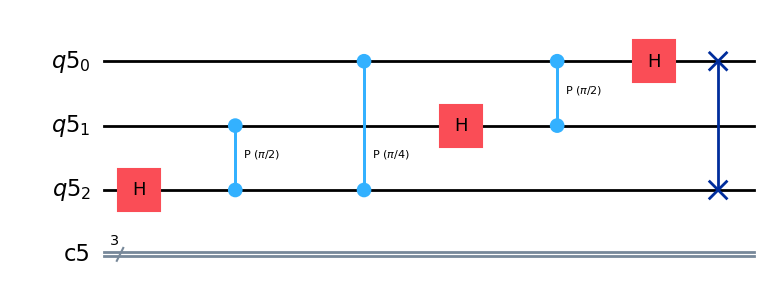

In [10]:
# Example: Circuit construction of 3 qubits QFT
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

qc.h(2)
qc.cp(pi/2, 1, 2) # Controlled-phase gate from qubit 1 to qubit 2
qc.cp(pi/4, 0, 2)
qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)
qc.swap(0, 2)
qc.draw("mpl")

In [11]:
bin(5)

'0b101'

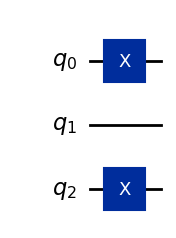

In [16]:
# Encode to qubitss
qc = QuantumCircuit(3)

# Encord the state 5
qc.x(0)
qc.x(2)
qc.draw("mpl")

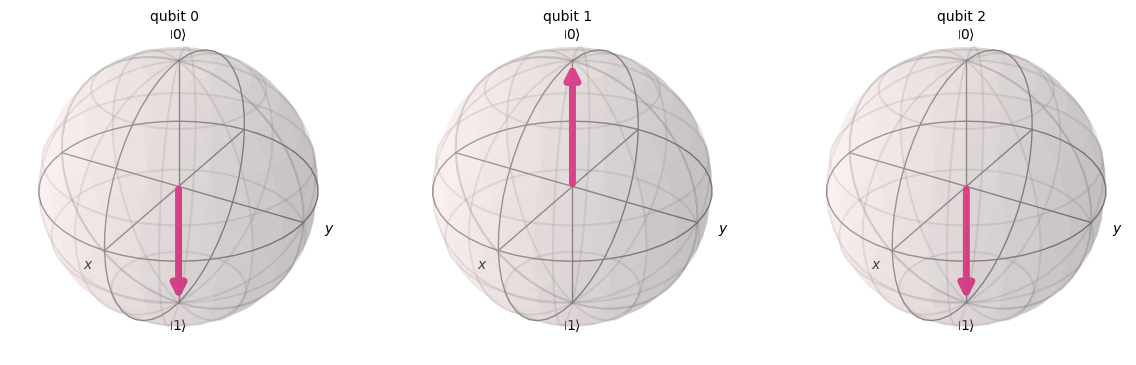

In [17]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

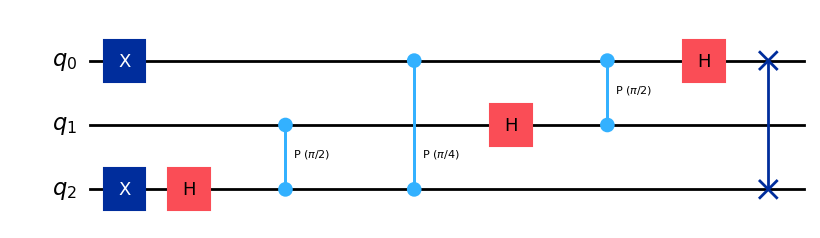

In [18]:
# Add QFT to state |5>
qc.h(2)
qc.cp(pi/2, 1, 2) # Controlled-phase gate from qubit 1 to qubit 2
qc.cp(pi/4, 0, 2)
qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)
qc.swap(0, 2)
qc.draw("mpl")

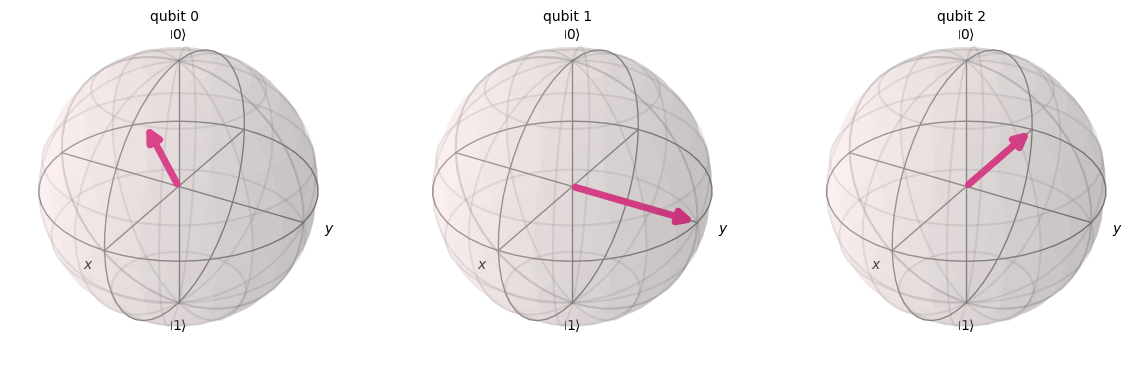

In [19]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

## Quantum Phase Estimation (QPE)

In [70]:
# Let's use T gate as an example of QPE abd estimate its phase theta.
qpe = QuantumCircuit(4, 3)
qpe.x(3) # q3 is eigenstate

for qubit in range(3):
    qpe.h(qubit)

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(pi/4, counting_qubit, 3)
    repetitions *= 2

In [71]:
from qiskit.circuit.library import QFT

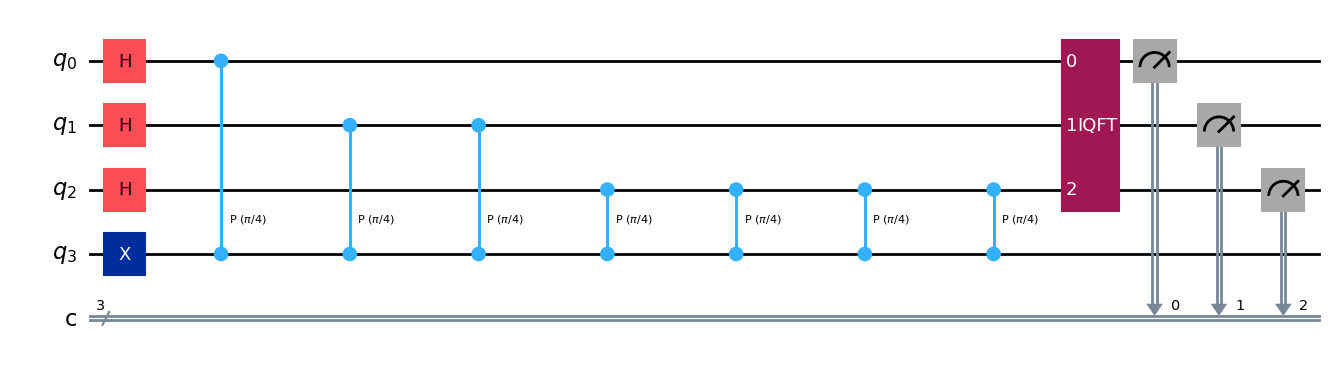

In [72]:
# Apply inverse QFT
qpe.append(QFT(3, inverse=True), [0,1,2])

for i in range(3):
    qpe.measure(i, i)
qpe.draw("mpl")

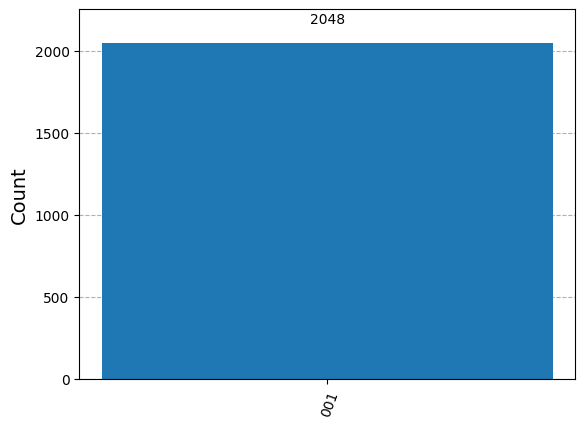

In [65]:
aer_sim = AerSimulator()
shots = 2048

pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
t_qpe = pm.run(qpe)

sampler = SamplerV2(mode=aer_sim)
job = sampler.run([t_qpe], shots=shots)
result = job.result()
answer = result[0].data.c.get_counts()

plot_histogram(answer)

In [69]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

service = QiskitRuntimeService(channel="ibm_quantum")

In [73]:
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=4)
backend.name

'ibm_kyiv'

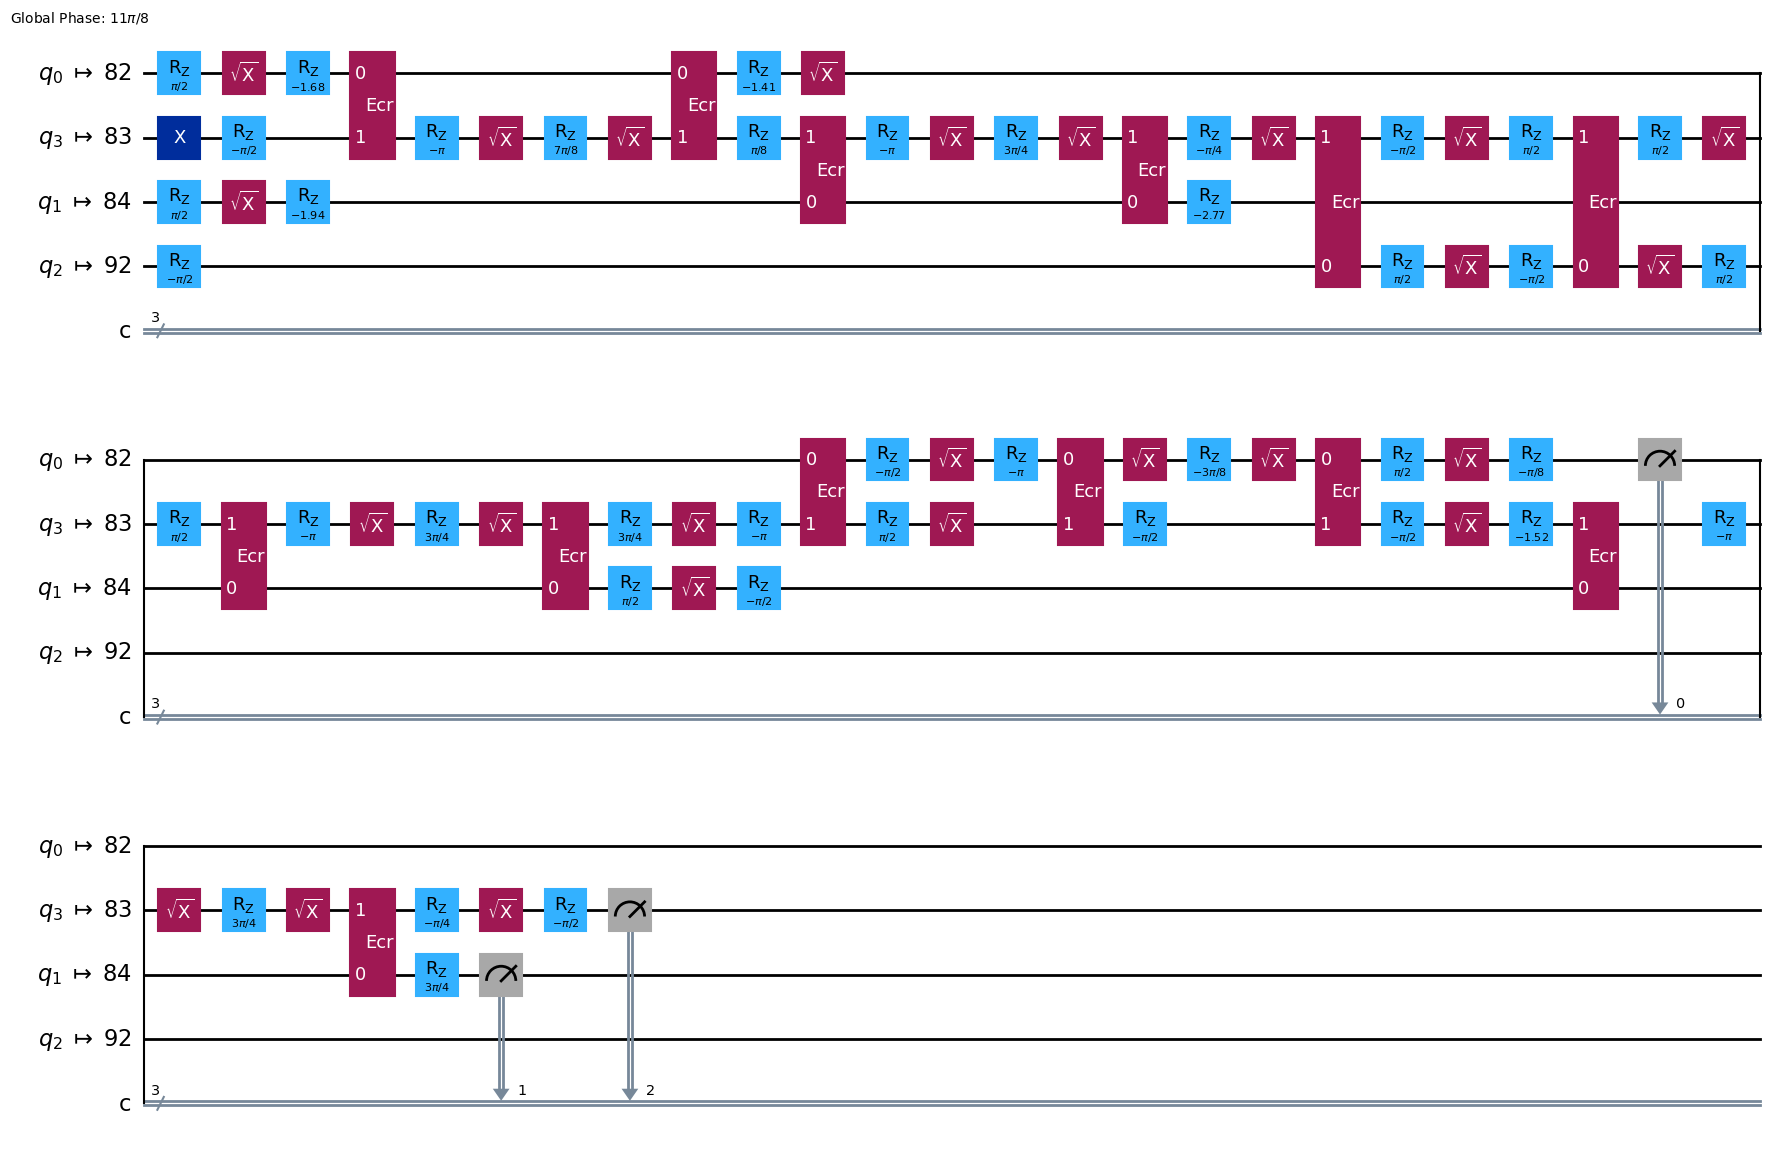

In [74]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qpe)

qc_compiled.draw("mpl", idle_wires=False)

In [75]:
real_sampler = SamplerV2(mode=backend)
job = real_sampler.run([qc_compiled], shots=1024)
print("job id:", job.job_id())

job id: cynh73m01rbg008gmm50


In [ ]:
job = service.job('cynh73m01rbg008gmm50')
job.status()